# Direct Marketing Analysis

This notebook performs an analysis on the direct marketing data. The steps include data loading, exploratory data analysis, feature selection, model building, and evaluation.


In this project, we will ingest the [data](https://archive.ics.uci.edu/dataset/222/bank+marketing), which has no missing values and thus requires no data cleaning. We will conduct an analysis to identify the variables closely linked to customers purchasing additional services and examine how these variables affect the chances of a successful marketing strategy. Based on our findings, we will provide recommendations to better utilise these variables to increase efficiency and customer purchases.



Dataset:
* `age`: Age of the customer
* `job`: Job type
* `marital`: Marital status
* `education`: Education level
* `default`: Has credit in default? (yes/no)
* `balance`: Average yearly balance in euros
* `housing`: Has housing loan? (yes/no)
* `loan`: Has personal loan? (yes/no)
* `contact`: Contact communication type (cellular/telephone)
* `day`: Last contact day of the month
* `month`: Last contact month of year
* `duration`: Last contact duration in seconds
* `campaign`: Number of contacts performed during this campaign
* `pdays`: Number of days since the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
* `previous`: Number of contacts performed before this campaign
* `poutcome`: Outcome of the previous marketing campaign (unknown/success/failure/other)
* `y`: Has the client subscribed a term deposit? (yes/no)`

## 1. Loading the data and displaying initial data information 

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from scipy.stats import pointbiserialr, chi2_contingency
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [2]:
def load_data(file_path):
    df = pd.read_csv(file_path, delimiter=';')
    return df

def display_data_info(df):
    print('\nDirect Marketing Data------------------')
    print(df.head())
    print('\nChecking unique values in categorical variables------------------')
    for col in df.select_dtypes(include='object').columns:
        print(df[col].unique())
    print('\nChecking for missing values and the data type------------------')
    print(df.info())
    print('\nDescriptive Statistics:------------------')
    print(df.describe())
    return df

file_path = 'bank.csv'
df = load_data(file_path)
df = display_data_info(df)

df.head()


Direct Marketing Data------------------
   age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome   y  
0  cellular   19   oct        79         1     -1         0  unknown  no  
1  cellular   11   may       220         1    339         4  failure  no  
2  cellular   16   apr       185         1    330         1  failure  no  
3   unknown    3   jun       199         4     -1         0  unknown  no  
4   unknown    5   may       226         1     -1         0  unknown  no  

Checking unique values in categorical variables------------------
['u

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


## 2. Exploratory Data Analysis

### Visualise feature distributions

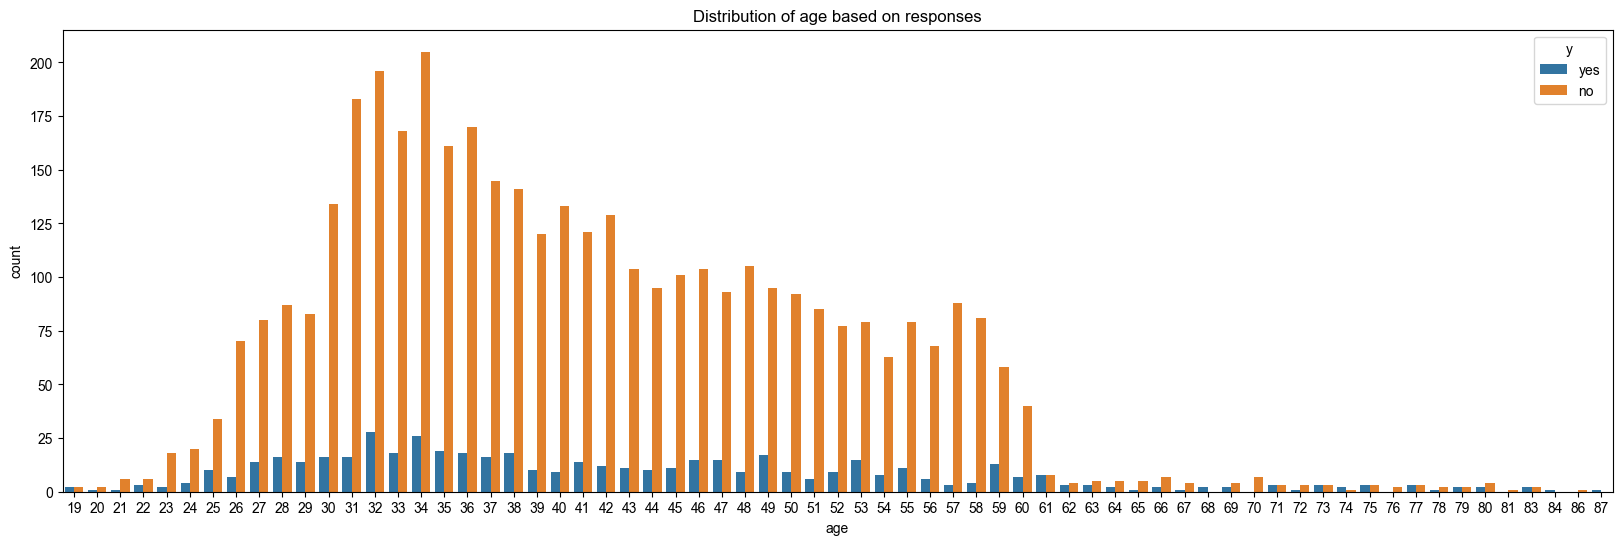

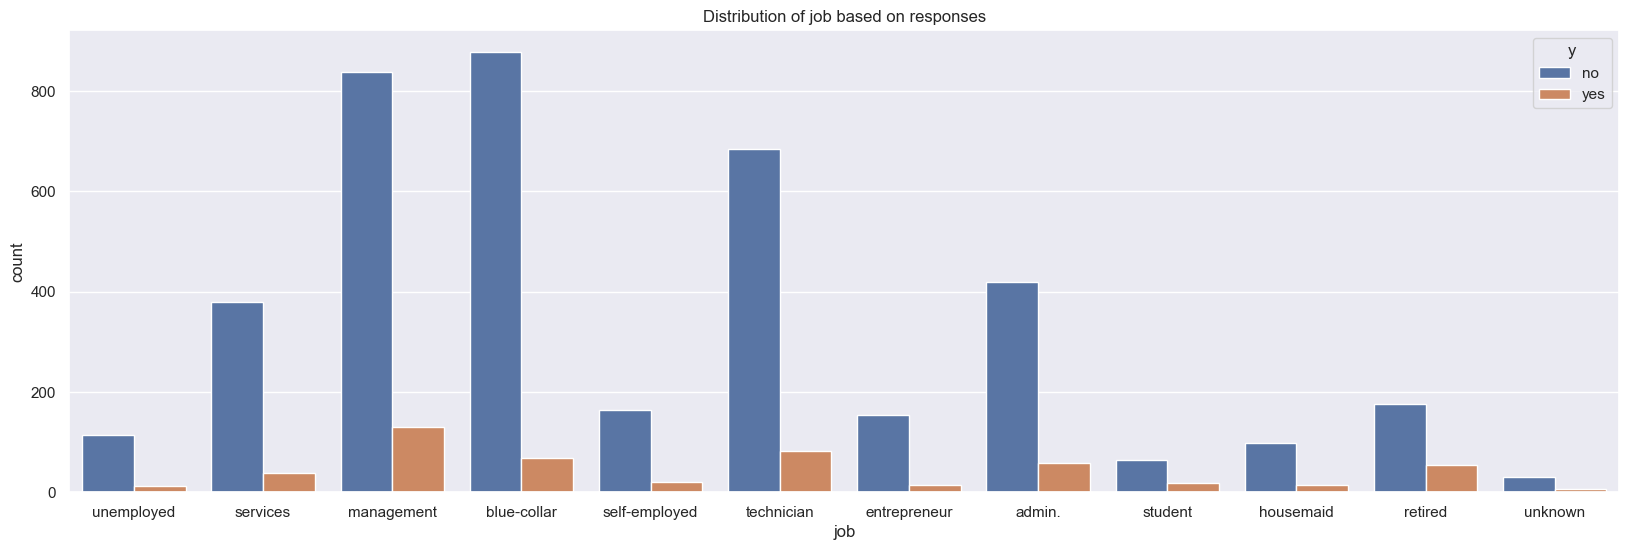

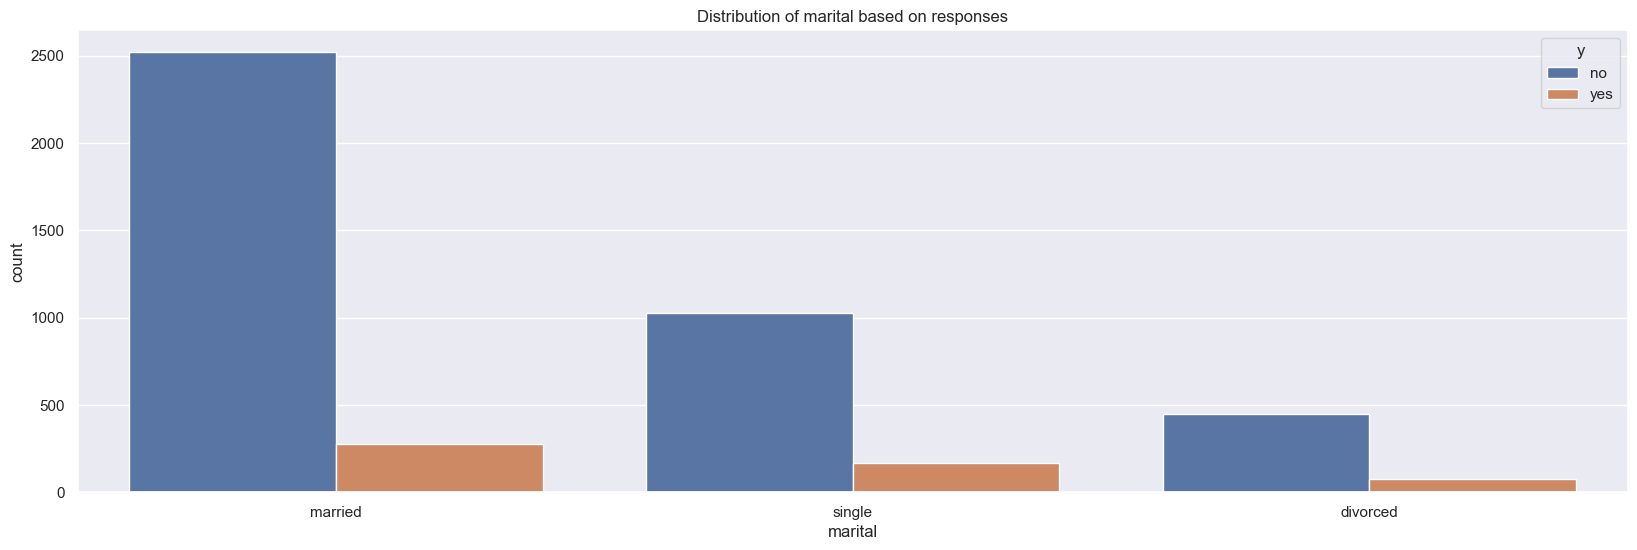

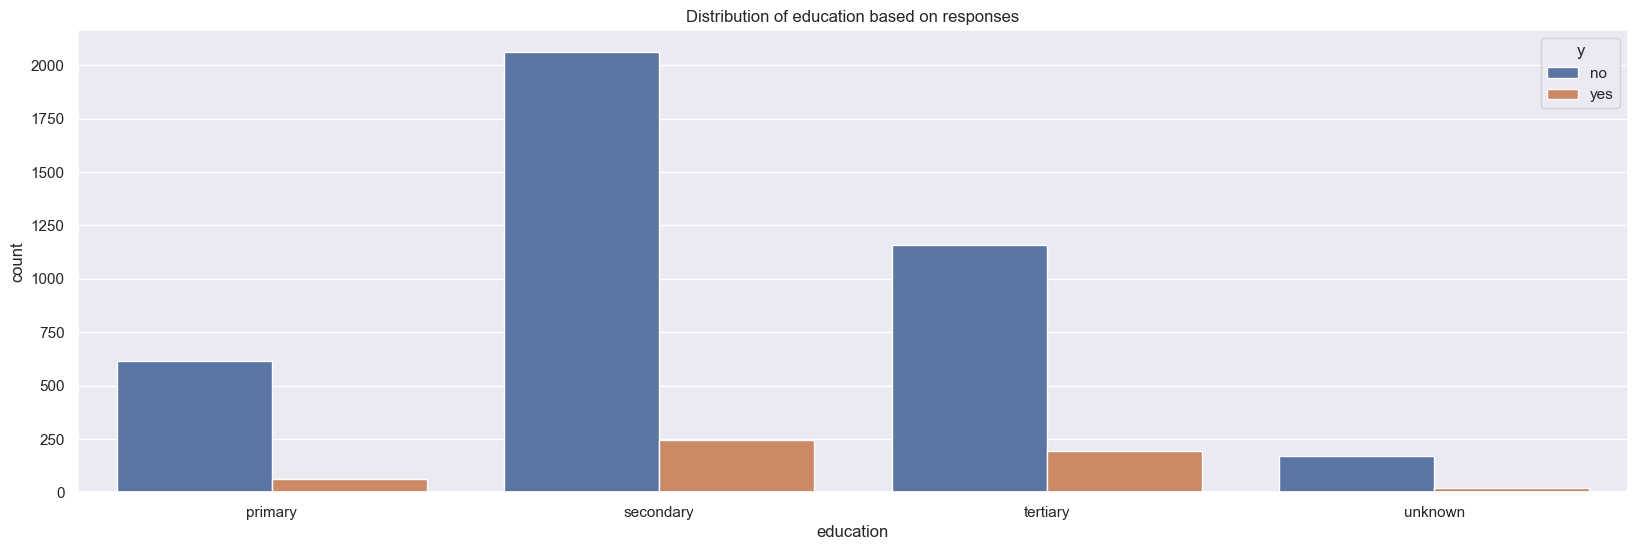

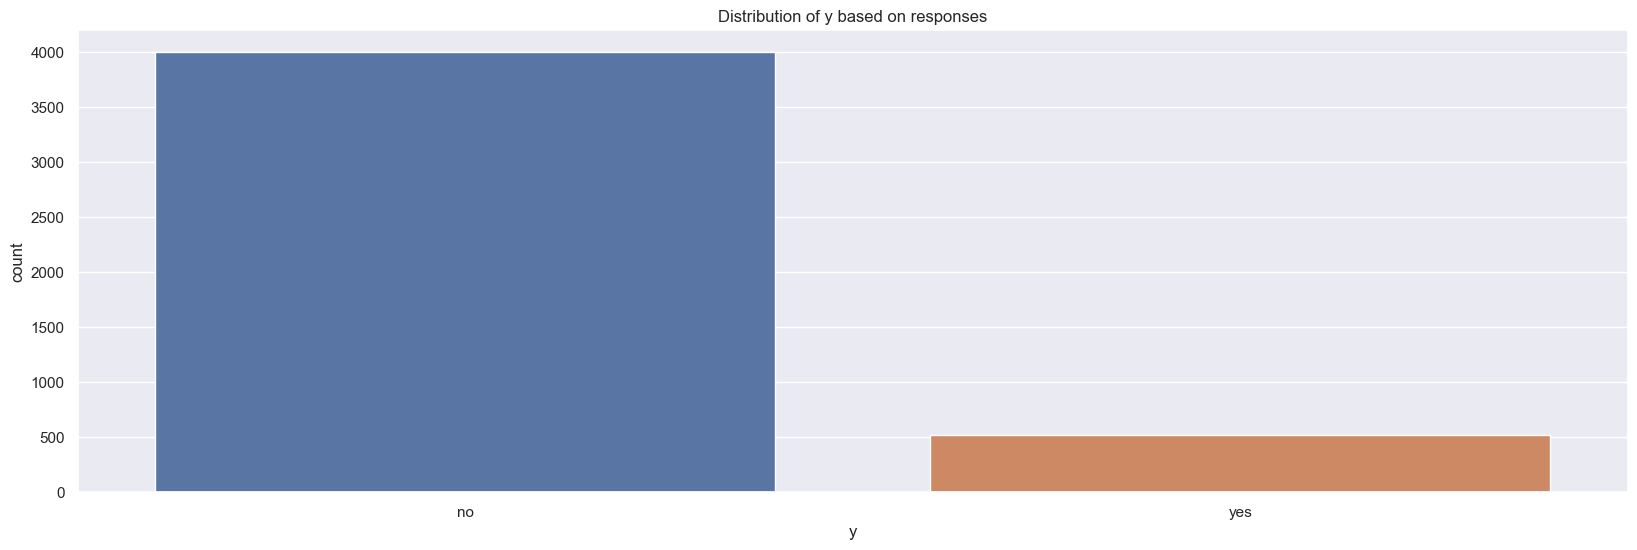

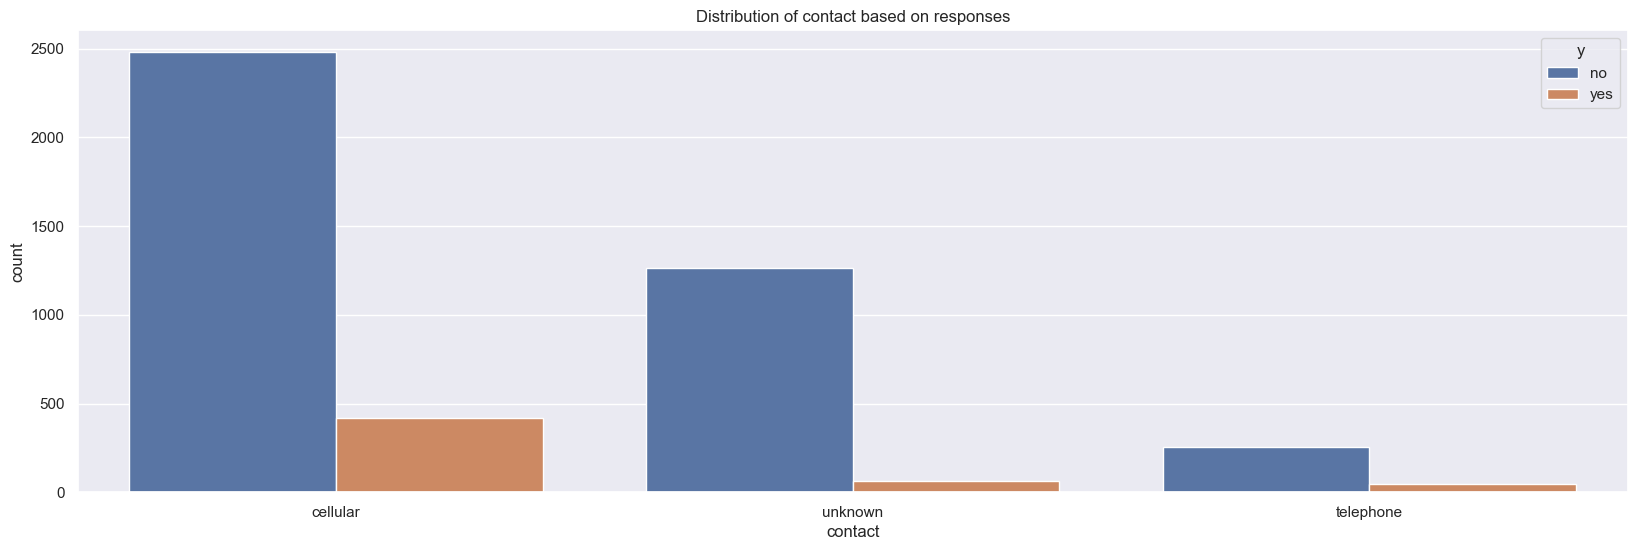

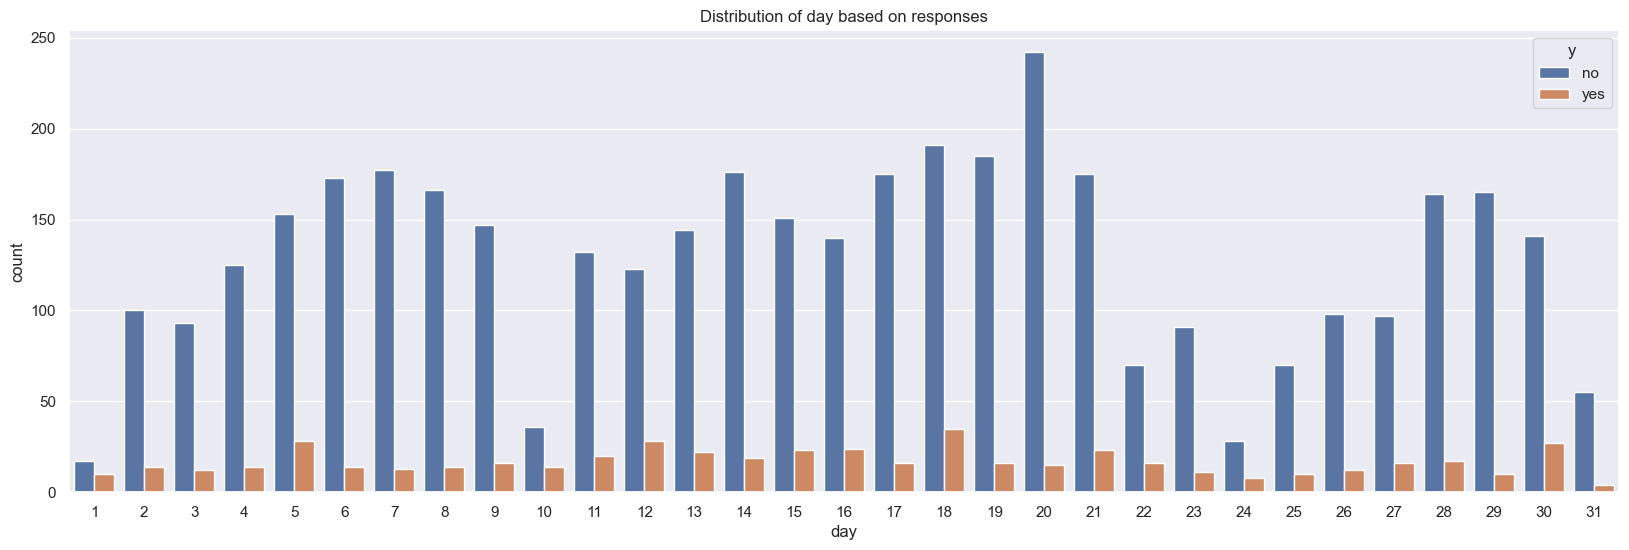

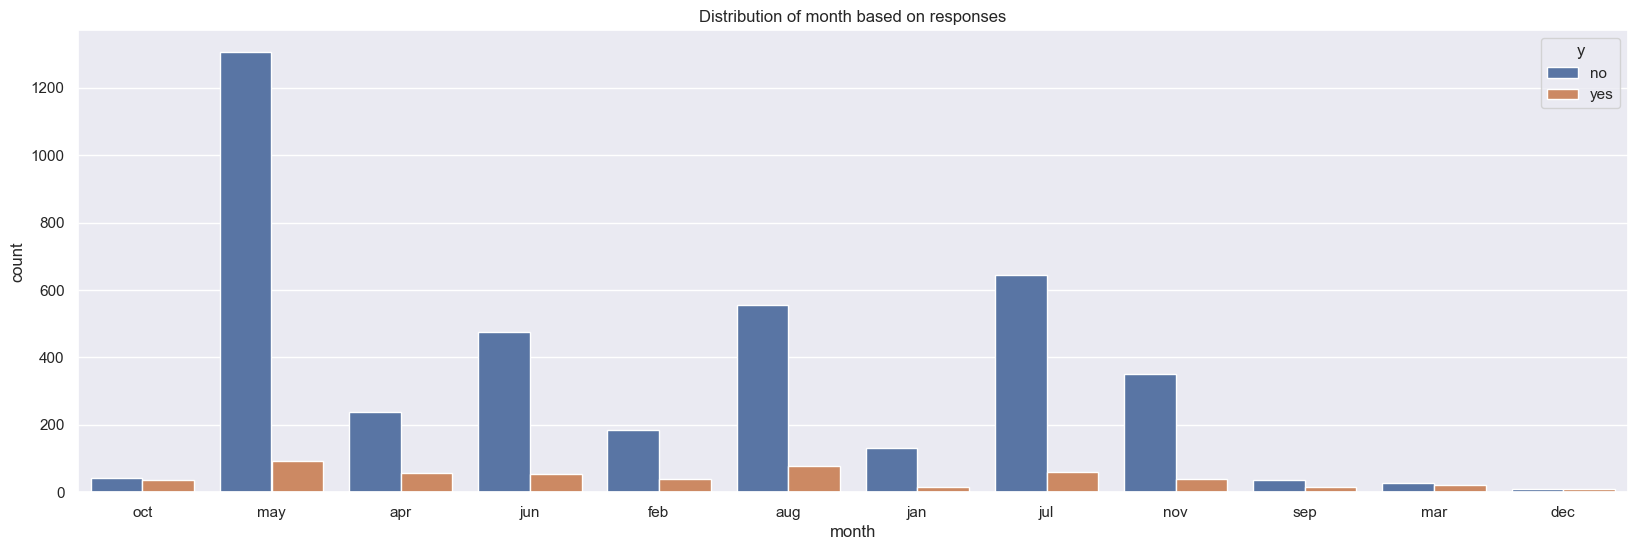

In [3]:
def distribution_of_features(df, columns):
    plt.figure(figsize=(20, 6))
    sns.countplot(data=df, x=columns, hue='y')
    sns.set(style='darkgrid')
    plt.xticks()
    plt.title(f'Distribution of {columns} based on responses')
    plt.show()

distribution_of_features(df, 'age')
distribution_of_features(df, 'job')
distribution_of_features(df, 'marital')
distribution_of_features(df, 'education')
distribution_of_features(df, 'y')
distribution_of_features(df, 'contact')
distribution_of_features(df, 'day')
distribution_of_features(df, 'month')


### Campaign performance visualisation 

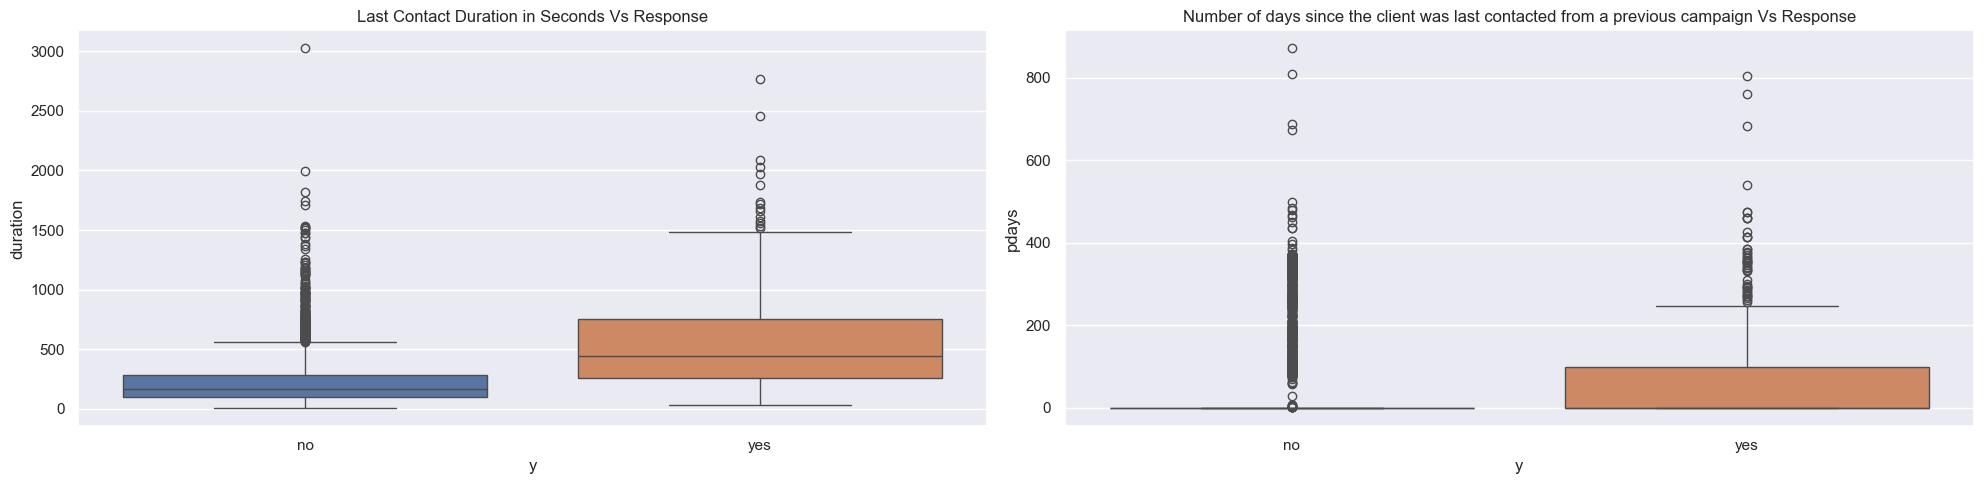

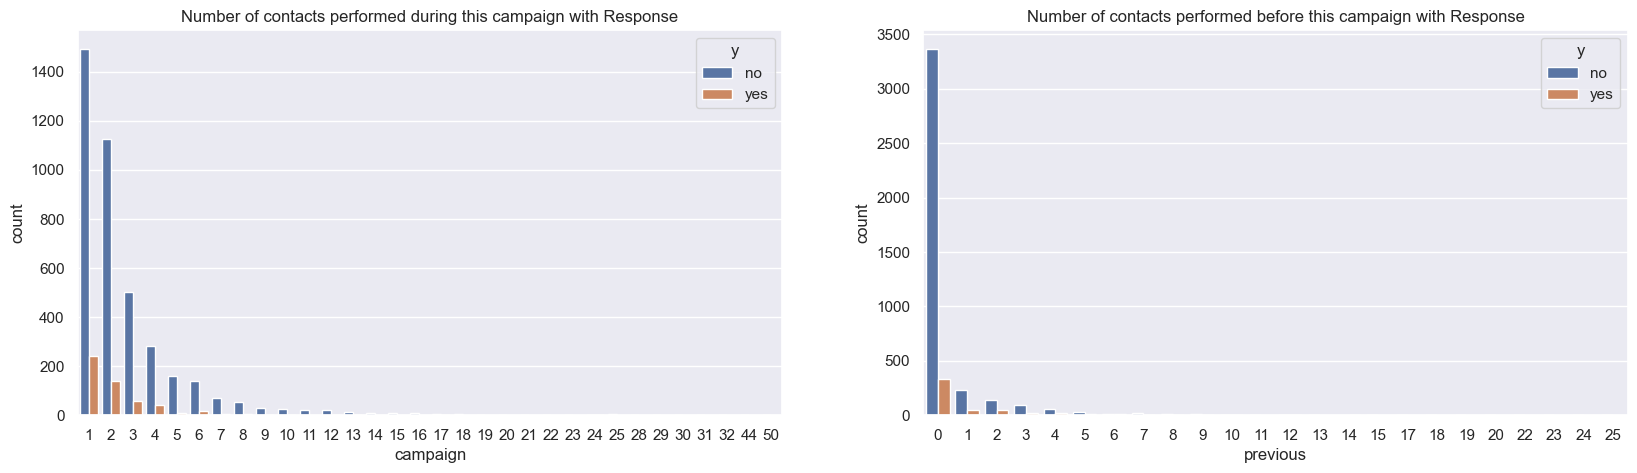

In [4]:
def campaign_performance(df):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    sns.boxplot(x="y", y='duration', data=df, ax=axes[0], hue='y')
    axes[0].set_title('Last Contact Duration in Seconds Vs Response')

    sns.boxplot(x="y", y='pdays', data=df, ax=axes[1], hue='y')
    axes[1].set_title('Number of days since the client was last contacted from a previous campaign Vs Response')

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    sns.countplot(data=df, x='campaign', hue='y', ax=axes[0])
    axes[0].set_title('Number of contacts performed during this campaign with Response')
    plt.xticks()

    sns.countplot(data=df, x='previous', hue='y', ax=axes[1])
    axes[1].set_title('Number of contacts performed before this campaign with Response')
    plt.xticks()

    plt.show()

campaign_performance(df)


### Correlations: Numerical Values with Biserial Correlation

Examining the correlation between the numerical values and the target variable `y` using **biserial correlation**. It is a statistically method used to measure the realtionship between a continuous value and a binary variable.

In [5]:
#Biserial correlation analysis
def biserial_correlation(df):
    df['y_numeric'] = df['y'].map({'yes': 1, 'no': 0})
    numeric_columns = list(df.select_dtypes(include=np.number).columns)
    numeric_columns.remove('y_numeric')

    corr_results = {}
    for column in numeric_columns:
        corr, p_value = pointbiserialr(x=df['y_numeric'], y=df[column])
        corr_results[column] = {'correlation': corr, 'p_value': p_value}

    corr_df = pd.DataFrame(corr_results).T
    filtered_corr_df = corr_df[corr_df.p_value <= 0.05]
    filtered_numerical_features = list(filtered_corr_df.index)
    return filtered_numerical_features, corr_df

filtered_numerical_features, corr_df = biserial_correlation(df)
print('Filtered numerical features:', filtered_numerical_features)
corr_df.round(6)

Filtered numerical features: ['age', 'duration', 'campaign', 'pdays', 'previous']


,correlation,p_value
age,0.045092,0.002425
balance,0.017905,0.228716
day,-0.011244,0.449735
duration,0.401118,0.000000
campaign,-0.061147,0.000039
pdays,0.104087,0.000000
previous,0.116714,0.000000


### Segmentation: Categorical Values With Chi-Squared Test

In [6]:
# Chi-squared test analysis
def chi_squared_test(df):
    categorical_columns = list(df.select_dtypes(include='object').columns)
    categorical_columns.remove('y')

    def chi_sqaure_test(column):
        crosstab_table = pd.crosstab(df[column], df['y'])
        chi2, p_value, dof, expected = chi2_contingency(crosstab_table)
        return chi2, p_value

    chi_results = {}
    for column in categorical_columns:
        chi2, p_value = chi_sqaure_test(column)
        chi_results[column] = {'chi2': chi2, 'p_value': p_value}

    chi_df = pd.DataFrame(chi_results).T
    filtered_chi_df = chi_df[chi_df.p_value <= 0.05]
    filtered_categorical_features = list(filtered_chi_df.index)
    return filtered_categorical_features, chi_df

filtered_categorical_features, chi_df = chi_squared_test(df)
print('Filtered categorical features:', filtered_categorical_features)
chi_df.round(6)

Filtered categorical features: ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'poutcome']


,chi2,p_value
job,68.988286,0.000000
marital,19.030056,0.000074
education,15.236580,0.001625
default,0.000000,1.000000
housing,48.884628,0.000000
loan,21.871822,0.000003
contact,87.869857,0.000000
month,250.500063,0.000000
poutcome,386.877387,0.000000


## 3. Feature Selection

### Address categorical data and check for collinearity

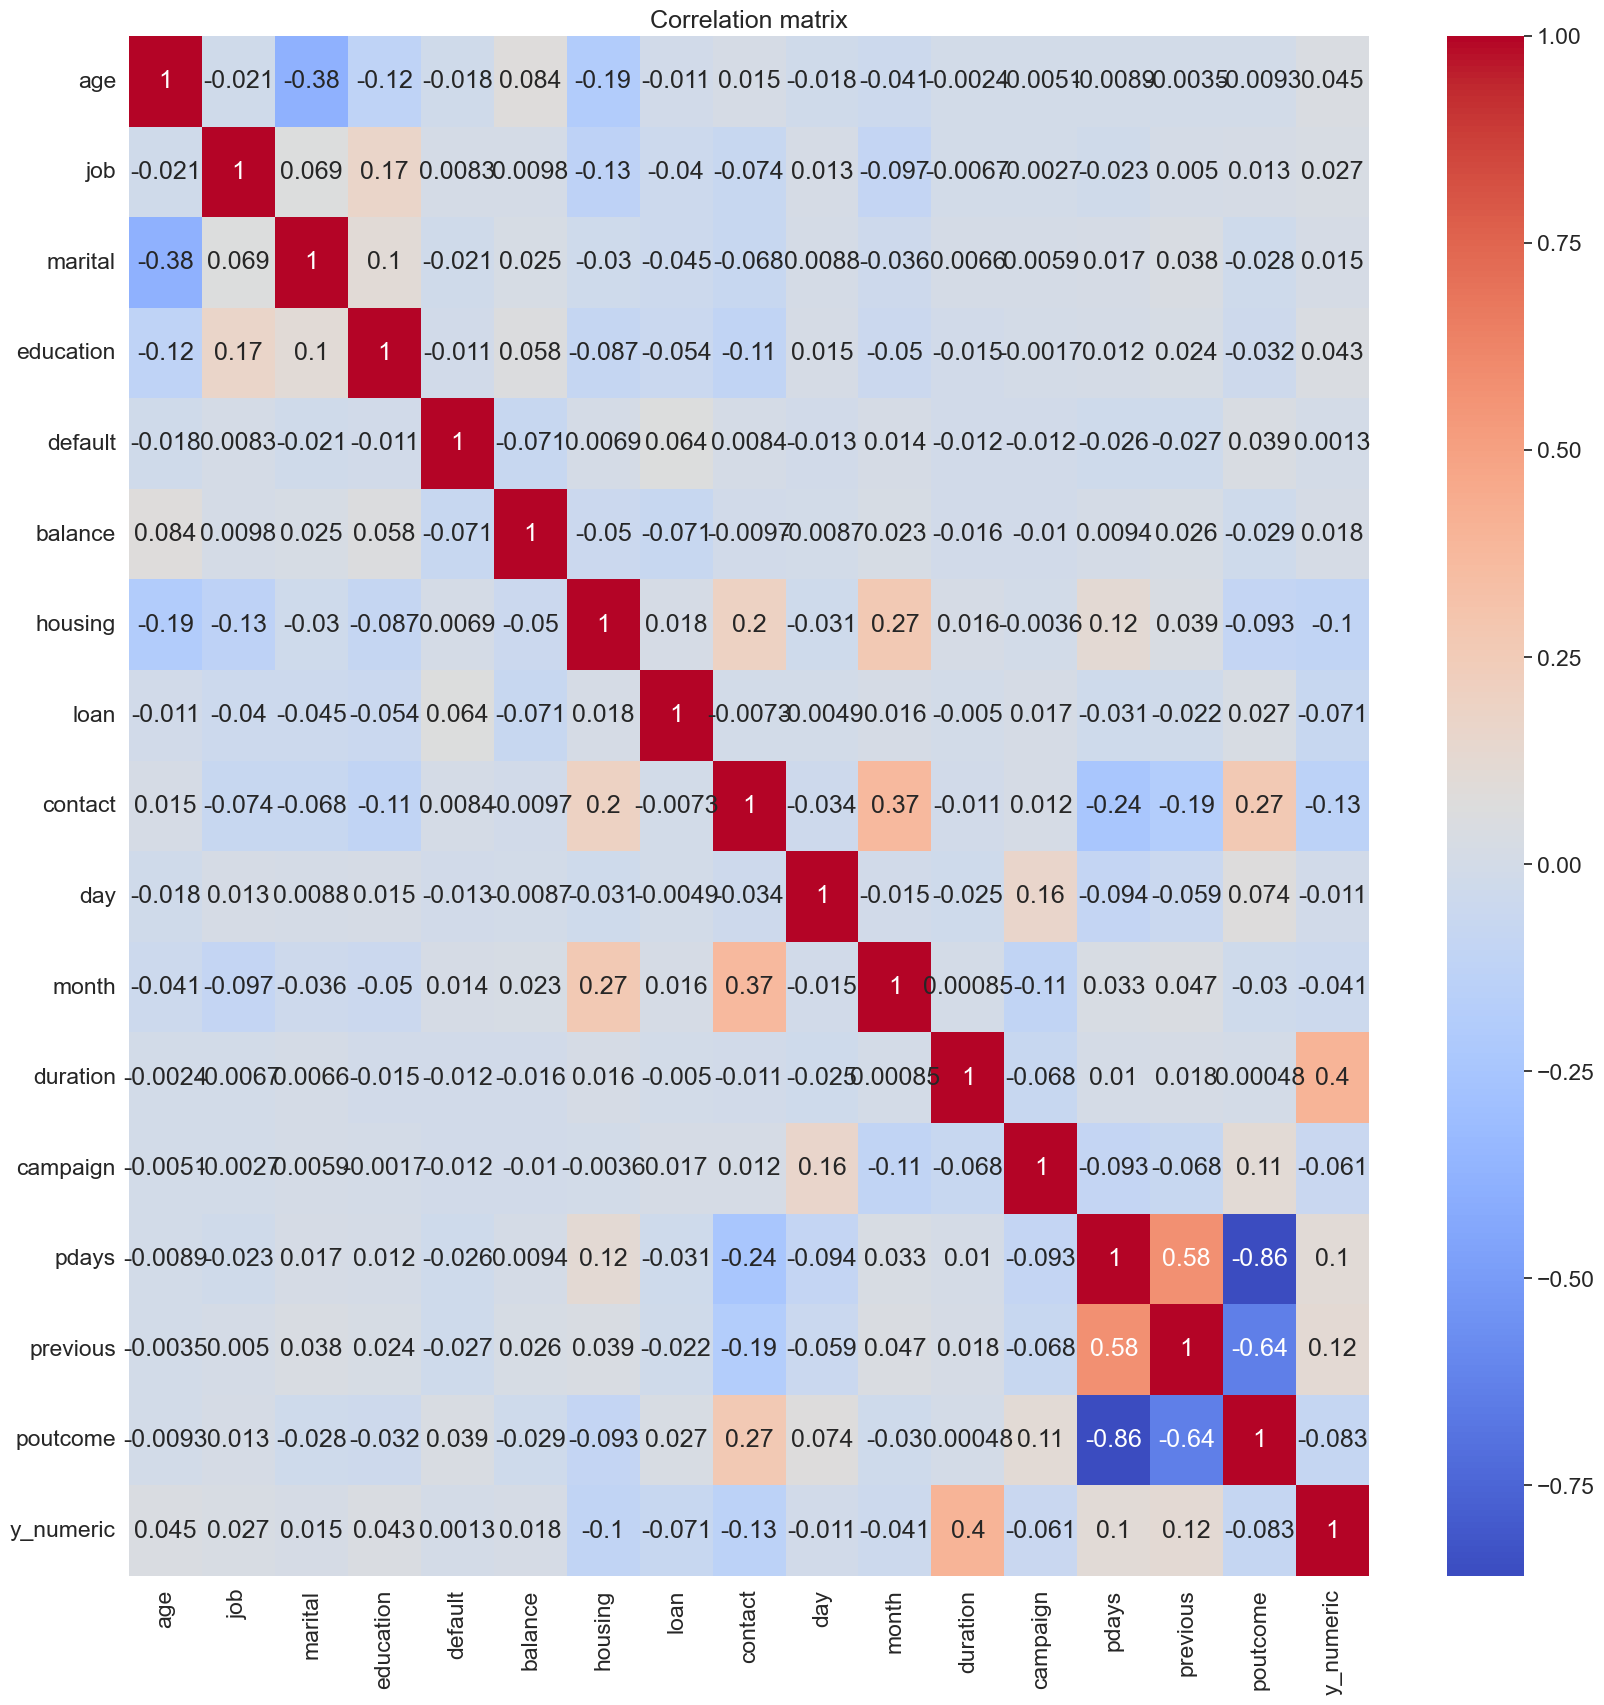

Selected features: ['age', 'duration', 'campaign', 'pdays', 'previous', 'job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'poutcome']


In [7]:
def address_categorical_data(df, filtered_numerical_features, filtered_categorical_features):
    le = LabelEncoder()
    df_copy = df.copy()

    df_copy.drop(columns=['y'], inplace=True)
    for col in df_copy.select_dtypes(include='object').columns:
        df_copy[col] = le.fit_transform(df_copy[col])

    plt.figure(figsize=(20, 20))
    sns.set(font_scale=1.5)
    sns.heatmap(df_copy.corr(), cmap='coolwarm', annot=True)
    plt.title('Correlation matrix')
    plt.show()

    select_features = filtered_numerical_features + filtered_categorical_features
    return df_copy, select_features

df_copy, select_features = address_categorical_data(df, filtered_numerical_features, filtered_categorical_features)
print('Selected features:', select_features)


## 4. Model Building 

### Balance the data using undersampling

In [8]:
def balance_data(df_copy):
    count_class_0, count_class_1 = df_copy.y_numeric.value_counts()

    df_class_0 = df_copy[df_copy['y_numeric'] == 0]
    df_class_1 = df_copy[df_copy['y_numeric'] == 1]

    df_class_0_under = df_class_0.sample(count_class_1, random_state=1)
    df_under_sample = pd.concat([df_class_0_under, df_class_1], axis=0)

    return df_under_sample

df_under_sample = balance_data(df_copy)
print('Balanced class distribution:\n', df_under_sample.y_numeric.value_counts())

Balanced class distribution:
 0    521
1    521
Name: y_numeric, dtype: int64


### Split the data into training and testing sets

In [9]:
# Split the data into training and testing sets
def split_data(df_under_sample, select_features):
    X = df_under_sample[select_features]
    y = df_under_sample['y_numeric']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(df_under_sample, select_features)
print('Training data class distribution:\n', y_train.value_counts())
print('Testing data class distribution:\n', y_test.value_counts())


Training data class distribution:
 1    417
0    416
Name: y_numeric, dtype: int64
Testing data class distribution:
 0    105
1    104
Name: y_numeric, dtype: int64


### Select and train the best model using GridSearchCV

In [10]:
def select_model(X, y):
    all_X = X
    all_y = y
    
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        }
    ]

    best_model = None
    best_precision_score = 0
    
    for model in models:
        print (model['name'])
        print ('-'*len(model['name']))
    
        grid = GridSearchCV(model['estimator'], param_grid=model['hyperparameters'], cv=10, scoring ='precision')
        grid.fit(all_X, all_y)
        model['best_params'] = grid.best_params_
        model['best_precision_score'] = grid.best_score_
        model['best_model'] = grid.best_estimator_

    
        print('Best Precision Score: {}'.format(model['best_precision_score']))
        print('Best parameters: {} \n'.format(model['best_params']))

        if model['best_precision_score'] > best_precision_score:
            best_precision_score = model['best_precision_score']
            best_model = model['best_model']

    
    print ('-'*len(model['name']))
    print('Best overall model:')
    print('Model:', best_model)
    print('Best Precision Score:', best_precision_score)
    
    return best_model, models

best_model, models  = select_model(X_train,y_train)

LogisticRegression
------------------
Best Precision Score: 0.8001677119292889
Best parameters: {'solver': 'liblinear'} 

KNeighborsClassifier
--------------------
Best Precision Score: 0.7914582537947155
Best parameters: {'algorithm': 'brute', 'n_neighbors': 11, 'p': 1, 'weights': 'uniform'} 

RandomForestClassifier
----------------------
Best Precision Score: 0.8185944979097144
Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 9} 

----------------------
Best overall model:
Model: RandomForestClassifier(criterion='entropy', max_depth=5, max_features='log2',
                       min_samples_leaf=5, n_estimators=9, random_state=1)
Best Precision Score: 0.8185944979097144


## 5. Evaluate the selected model 

In [11]:
def evaluate_model(best_model, X_test, y_test):
    predictions = best_model.predict(X_test)
    cl_rep = classification_report(y_test, predictions)
    return cl_rep

print('Model Metrics:')
print(evaluate_model(best_model, X_test, y_test))


Model Metrics:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       105
           1       0.81      0.84      0.82       104

    accuracy                           0.82       209
   macro avg       0.82      0.82      0.82       209
weighted avg       0.82      0.82      0.82       209



### Best Features and Feature Importance - Recursive Feature Elimination

In most cases, I will gravitate towards the hyperparamter optimised Random Forest Classifier as the model of choice (as these are very accurate, can combat any overfitting, can pick up non-linear characterisitics). Lets see the level of importance it categories the features

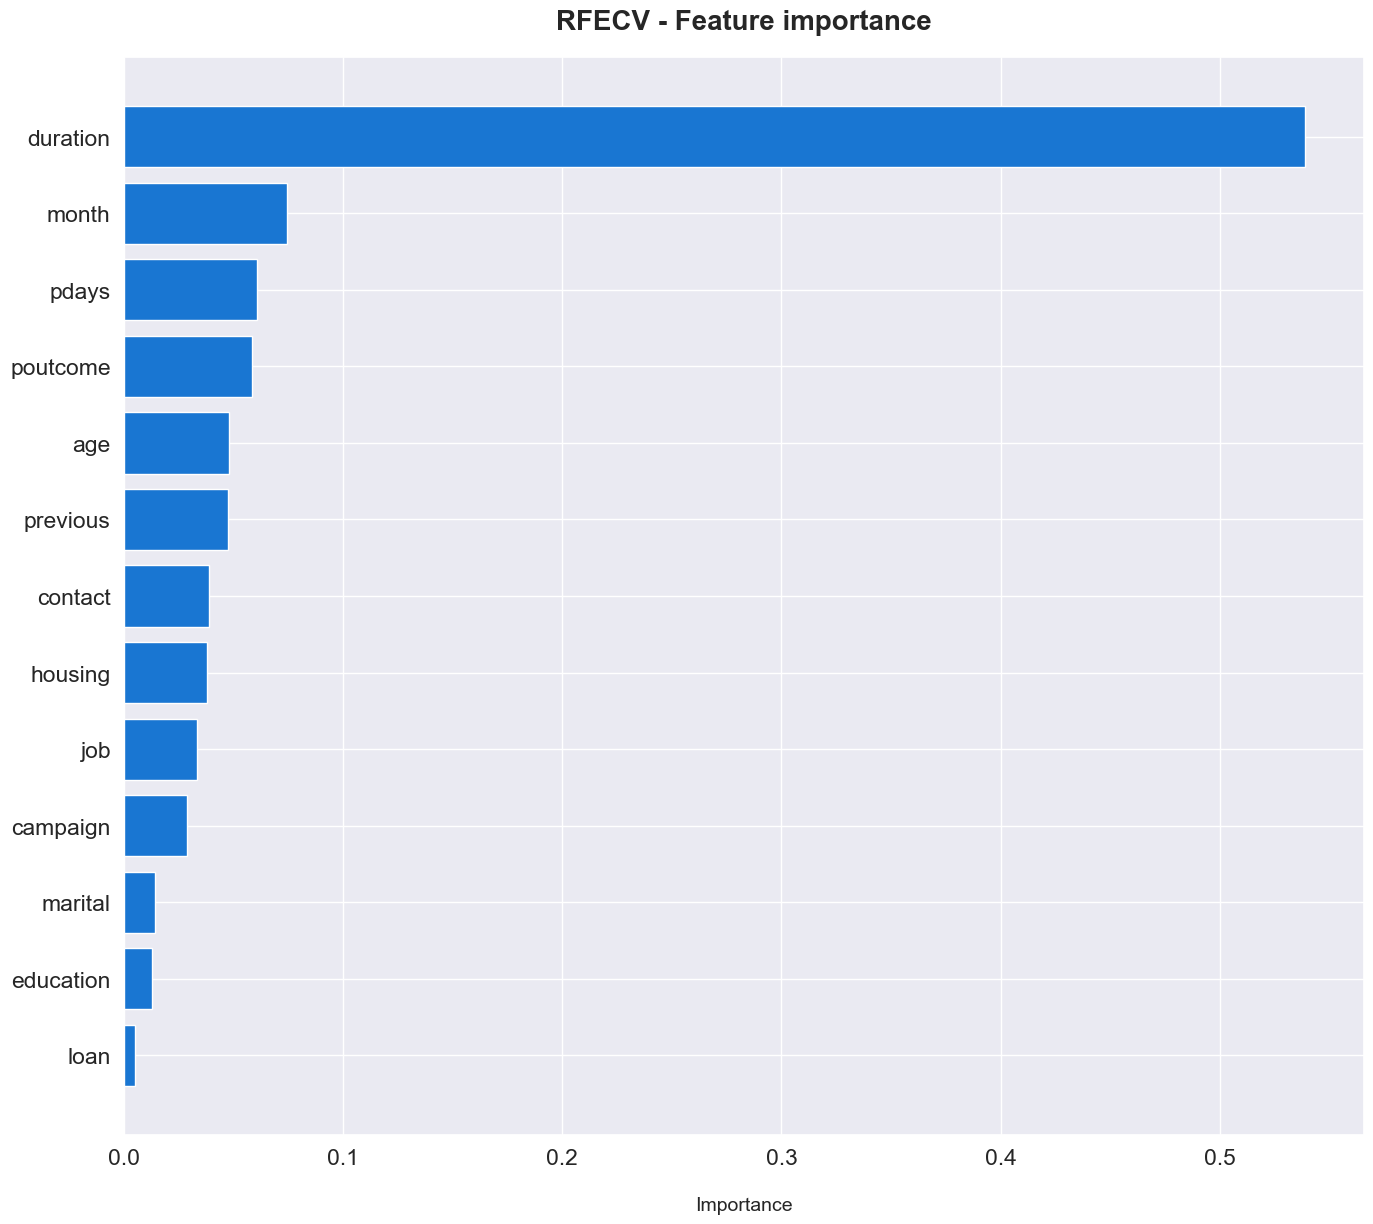

In [12]:
def recursive_feature_elimination(models, X_train, y_train, select_features):
    def get_best_random_forest_model(models):
        for model in models:
            if model["name"] == "RandomForestClassifier":
                return model["best_model"]

    best_rf_model = get_best_random_forest_model(models)

    rfecv = RFECV(estimator=best_rf_model, step=2, scoring='precision', min_features_to_select=len(select_features))
    rfecv.fit(X_train, y_train)

    dset = pd.DataFrame()
    dset['attr'] = X_train.columns
    dset['importance'] = rfecv.estimator_.feature_importances_

    dset = dset.sort_values(by='importance', ascending=True)

    plt.figure(figsize=(16, 14))
    plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
    plt.title('RFECV - Feature importance', fontsize=20, fontweight='bold', pad=20)
    plt.xlabel('Importance', fontsize=14, labelpad=20)
    plt.show()

recursive_feature_elimination(models, X_train, y_train, select_features)